In [1]:
import os
import shutil
import random
import zipfile
import tarfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

# To ignore some warnings about Image metadata that Pillow prints out
import warnings
warnings.filterwarnings("ignore")

In [13]:
# Download datasets

# Cats and dogs
!wget https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip

# Caltech birds
!wget https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar

# Download pretrained models and training histories
!wget -q -P /content/model-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/saved_model.pb
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-balanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-balanced/variables/variables.index
!wget -q -P /content/history-balanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-balanced/history-balanced.csv

!wget -q -P /content/model-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/saved_model.pb
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.data-00000-of-00001
!wget -q -P /content/model-imbalanced/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-imbalanced/variables/variables.index
!wget -q -P /content/history-imbalanced/ https://storage.googleapis.com/mlep-public/course_1/week2/history-imbalanced/history-imbalanced.csv

!wget -q -P /content/model-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/saved_model.pb
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.data-00000-of-00001
!wget -q -P /content/model-augmented/variables/ https://storage.googleapis.com/mlep-public/course_1/week2/model-augmented/variables/variables.index
!wget -q -P /content/history-augmented/ https://storage.googleapis.com/mlep-public/course_1/week2/history-augmented/history-augmented.csv

--2024-01-09 13:56:34--  https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.207, 142.251.6.207, 108.177.120.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/zip]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   141MB/s    in 7.2s    

2024-01-09 13:56:41 (109 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]

--2024-01-09 13:56:41--  https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.207, 142.251.6.207, 108.177.120.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1259479

## Combining the datasets

The raw images in these datasets can be found within the following paths:


In [14]:
cats_and_dogs_zip = '/content/kagglecatsanddogs_3367a.zip'
caltech_birds_tar = '/content/CUB_200_2011.tar'

base_dir = '/tmp/data'

Extracting the data into  `base_dir`

In [15]:
with zipfile.ZipFile(cats_and_dogs_zip, 'r') as my_zip:
  my_zip.extractall(base_dir)

with tarfile.open(caltech_birds_tar, 'r') as my_tar:
  my_tar.extractall(base_dir)

For the cats and dogs images no further preprocessing is needed as all exemplars of a single class are located in one directory: `PetImages\Cat` and `PetImages\Dog` respectively. Let's check how many images are available for each category:

In [17]:
base_dogs_dir = os.path.join(base_dir, 'PetImages/Dog')
base_cats_dir = os.path.join(base_dir,'PetImages/Cat')

print(f"There are {len(os.listdir(base_dogs_dir))} images of dogs")
print(f"There are {len(os.listdir(base_cats_dir))} images of cats")

There are 12501 images of dogs
There are 12501 images of cats


The Bird images dataset organization is quite different. This dataset is commonly used to classify species of birds so there is a directory for each species. Let's treat all species of birds as a single class. This requires moving all bird images to a single directory (`PetImages/Bird` will be used for consistency)

In [18]:
raw_birds_dir = '/tmp/data/CUB_200_2011/images'
base_birds_dir = os.path.join(base_dir,'PetImages/Bird')
os.mkdir(base_birds_dir)

for subdir in os.listdir(raw_birds_dir):
  subdir_path = os.path.join(raw_birds_dir, subdir)
  for image in os.listdir(subdir_path):
    shutil.move(os.path.join(subdir_path, image), os.path.join(base_birds_dir))

print(f"There are {len(os.listdir(base_birds_dir))} images of birds")

There are 11788 images of birds


It turns out that there is a similar number of images for each class you are trying to predict!

Sample cat image:


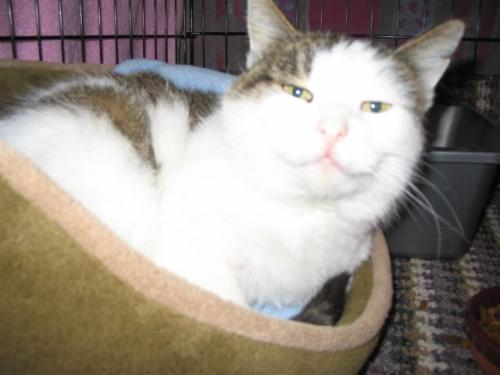


Sample dog image:


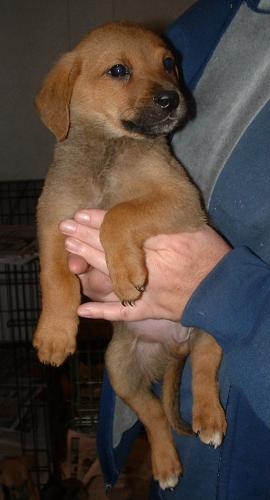


Sample bird image:


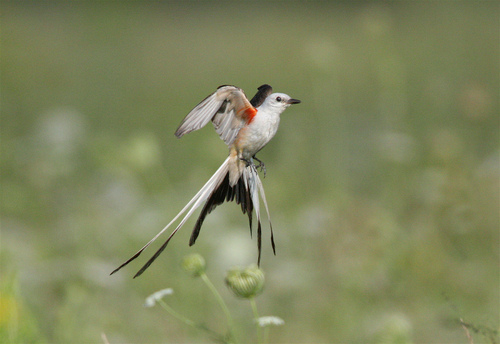

In [20]:
from IPython.display import Image, display

print("Sample cat image:")
display(Image(filename=f"{os.path.join(base_cats_dir, os.listdir(base_cats_dir)[random.randint(0,1000)])}"))
print("\nSample dog image:")
display(Image(filename=f"{os.path.join(base_dogs_dir, os.listdir(base_dogs_dir)[random.randint(0,1000)])}"))
print("\nSample bird image:")
display(Image(filename=f"{os.path.join(base_birds_dir, os.listdir(base_birds_dir)[random.randint(0,1000)])}"))

## Train / Evaluate Split

In [21]:
train_eval_dirs = ['train/cats', 'train/dogs', 'train/birds',
                   'eval/cats', 'eval/dogs', 'eval/birds']

for dir in train_eval_dirs:
  if not os.path.exists(os.path.join(base_dir, dir)):
    os.makedirs(os.path.join(base_dir, dir))

Now, let's define a function that will move a percentage of images from an origin folder to a destination folder as desired to generate the training and evaluation splits:

In [22]:
def move_to_destination(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.move(os.path.join(origin, image_name), destination)

And now you are ready to call the previous function and split the data:

In [23]:
# Move 70% of the images to the train dir
move_to_destination(base_cats_dir, os.path.join(base_dir, 'train/cats'), 0.7)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'train/dogs'), 0.7)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'train/birds'), 0.7)


# Move the remaining images to the eval dir
move_to_destination(base_cats_dir, os.path.join(base_dir, 'eval/cats'), 1)
move_to_destination(base_dogs_dir, os.path.join(base_dir, 'eval/dogs'), 1)
move_to_destination(base_birds_dir, os.path.join(base_dir, 'eval/birds'), 1)

1. Some images are corrupted and have zero bytes.
2. Cats vs dogs zip file included a `.db` file for each class that needs to be deleted.

**It is a good practice to always make sure that you are submitting files with the correct specifications to your training algorithm before start running it**

Running the following `bash` commands in the base directory will resolve these issues:

In [24]:
#removes all zero-byte files from the filesystem
!find /tmp/data/ -size 0 -exec rm {} +

#removes any file that does not have a `.jpg` extension
!find /tmp/data/ -type f ! -name "*.jpg" -exec rm {} +

In [25]:
#Let's check how many images you have available for each split and class after you remove the corrupted images:


print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'train/birds')))} images of birds for training\n")

print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/cats')))} images of cats for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/dogs')))} images of dogs for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'eval/birds')))} images of birds for evaluation")

There are 8750 images of cats for training
There are 8749 images of dogs for training
There are 8251 images of birds for training

There are 3749 images of cats for evaluation
There are 3750 images of dogs for evaluation
There are 3537 images of birds for evaluation


## An unexpected issue!

Let's face the first real life issue in this narrative! There was a power outage in your office and some hard drives were damaged and as a result of that, many of the images for `dogs` and `birds` have been erased. As a matter of fact, only 20% of the dog images and 10% of the bird images survived.

To simulate this scenario, let's quickly create a new directory called `imbalanced` and copy only the proportions mentioned above for each class.

In [26]:
for dir in train_eval_dirs:
  if not os.path.exists(os.path.join(base_dir, 'imbalanced/'+dir)):
    os.makedirs(os.path.join(base_dir, 'imbalanced/'+dir))

In [27]:
# Very similar to the one used before but this one copies instead of moving
def copy_with_limit(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.copy(os.path.join(origin, image_name), destination)

# Perform the copying
copy_with_limit(os.path.join(base_dir, 'train/cats'), os.path.join(base_dir, 'imbalanced/train/cats'), 1)
copy_with_limit(os.path.join(base_dir, 'train/dogs'), os.path.join(base_dir, 'imbalanced/train/dogs'), 0.2)
copy_with_limit(os.path.join(base_dir, 'train/birds'), os.path.join(base_dir, 'imbalanced/train/birds'), 0.1)

copy_with_limit(os.path.join(base_dir, 'eval/cats'), os.path.join(base_dir, 'imbalanced/eval/cats'), 1)
copy_with_limit(os.path.join(base_dir, 'eval/dogs'), os.path.join(base_dir, 'imbalanced/eval/dogs'), 0.2)
copy_with_limit(os.path.join(base_dir, 'eval/birds'), os.path.join(base_dir, 'imbalanced/eval/birds'), 0.1)

# Print number of available images
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/train/birds')))} images of birds for training\n")

print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/cats')))} images of cats for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/dogs')))} images of dogs for evaluation")
print(f"There are {len(os.listdir(os.path.join(base_dir, 'imbalanced/eval/birds')))} images of birds for evaluation")

There are 8750 images of cats for training
There are 1749 images of dogs for training
There are 825 images of birds for training

There are 3749 images of cats for evaluation
There are 750 images of dogs for evaluation
There are 353 images of birds for evaluation


create a model architecture and define a loss function, optimizer and performance metrics

In [28]:
from tensorflow.keras import layers, models, optimizers

def create_model():
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(3, activation='softmax')
  ])


  # Compile the model
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

  return model

In [29]:
# Create a model to use with the imbalanced dataset
imbalanced_model = create_model()

print(imbalanced_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

For training the model you will be using Keras' **ImageDataGenerator**, which has built-in functionalities to easily feed your model with raw, rescaled or even augmented image data.

Another cool functionality within ImageDataGenerator is the `flow_from_directory` method which allows to read images as needed from a root directory. This method needs the following arguments:

- `directory`: Path to the root directory where the images are stored.
- `target_size`: The dimensions to which all images found will be resized. Since images come in all kinds of resolutions, you need to standardize their size. 150x150 is used but other values should work well too.
- `batch_size`: Number of images the generator yields everytime it is asked for a next batch. 32 is used here.
- `class_mode`: How the labels are represented. Here "binary" is used to indicate that labels will be 1D. This is done for compatibility with the loss and evaluation metrics used when compiling the model.


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# No data augmentation for now, only normalizing pixel values
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Point to the imbalanced directory
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/imbalanced/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/imbalanced/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 11324 images belonging to 3 classes.
Found 4852 images belonging to 3 classes.


inspect that both generators use the same labels for each class:

In [31]:
print(f"labels for each class in the train generator are: {train_generator.class_indices}")
print(f"labels for each class in the validation generator are: {validation_generator.class_indices}")

labels for each class in the train generator are: {'birds': 0, 'cats': 1, 'dogs': 2}
labels for each class in the validation generator are: {'birds': 0, 'cats': 1, 'dogs': 2}


# Training a CNN with class imbalanced data

In [32]:
# Load pretrained model and history

imbalanced_history = pd.read_csv('history-imbalanced/history-imbalanced.csv')
imbalanced_model = tf.keras.models.load_model('model-imbalanced')

In [33]:
# Run only if you want to train the model yourself (this takes around 20 mins with GPU enabled)

# imbalanced_history = imbalanced_model.fit(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=50,
#     validation_data=validation_generator,
#     validation_steps=80)

To analyze the model performance properly, it is important to track different metrics such as accuracy and loss function along the training process. Let's define a helper function to handle the metrics through the training history,depending on the method you previously selected:

In [34]:
def get_training_metrics(history):

  # This is needed depending on if you used the pretrained model or you trained it yourself
  if not isinstance(history, pd.core.frame.DataFrame):
    history = history.history

  acc = history['sparse_categorical_accuracy']
  val_acc = history['val_sparse_categorical_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']

  return acc, val_acc, loss, val_loss

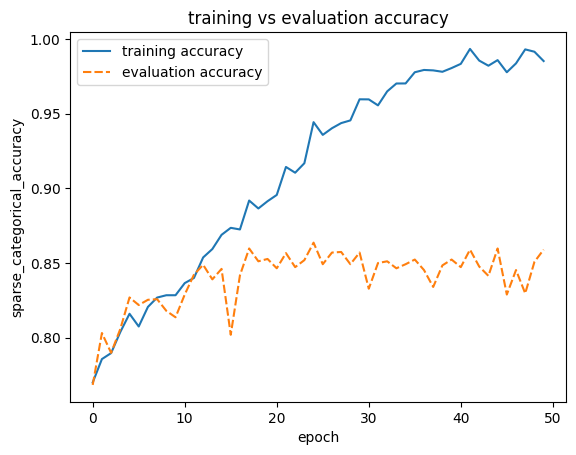

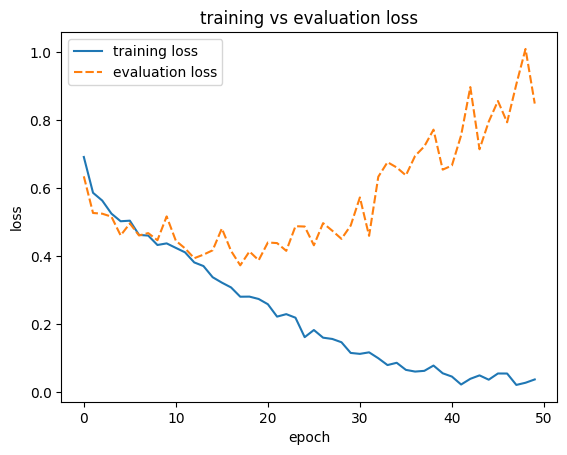

In [35]:
def plot_train_eval(history):
  acc, val_acc, loss, val_loss = get_training_metrics(history)

  acc_plot = pd.DataFrame({"training accuracy":acc, "evaluation accuracy":val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title('training vs evaluation accuracy')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('sparse_categorical_accuracy')
  plt.show()

  print("")

  loss_plot = pd.DataFrame({"training loss":loss, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title('training vs evaluation loss')
  loss_plot.set_xlabel('epoch')
  loss_plot.set_ylabel('loss')
  plt.show()



plot_train_eval(imbalanced_history)

From these two plots is quite evident that the model is overfitting the training data. However, the evaluation accuracy is still pretty high.

Let's dive a little deeper, and compute some additional metrics to explore if the class imbalance is hampering the model to perform well.

let's compare: the accuracy score,  the accuracy score balanced, and the confusion matrix.

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

In [37]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/imbalanced/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 4852 images belonging to 3 classes.


In [38]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions_imbalanced = imbalanced_model.predict(val_gen_no_shuffle)

# Get the argmax (since softmax is being used)
y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_imbalanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_imbalanced)}")

152/152 [==============================] - 39s 247ms/step
Accuracy Score: 0.8553173948887057
Balanced Accuracy Score: 0.741837557941167


Comparing the `accuracy` and `balanced accuracy` metrics, the class imbalance starts to become apparent. Now let's compute the `confusion matrix` of the predictions.

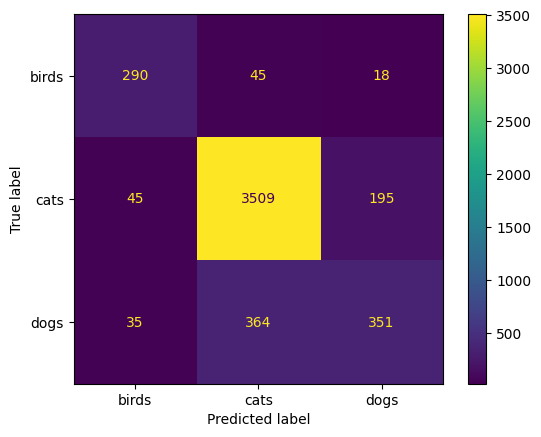

In [39]:
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

Notice that the class imbalance is also present in the evaluation set so the confusion matrix will show an overwhelming majority for cats.

In [40]:
misclassified_birds = (imbalanced_cm[1,0] + imbalanced_cm[2,0])/np.sum(imbalanced_cm, axis=0)[0]
misclassified_cats = (imbalanced_cm[0,1] + imbalanced_cm[2,1])/np.sum(imbalanced_cm, axis=0)[1]
misclassified_dogs = (imbalanced_cm[0,2] + imbalanced_cm[1,2])/np.sum(imbalanced_cm, axis=0)[2]

print(f"Proportion of misclassified birds: {misclassified_birds*100:.2f}%")
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified birds: 21.62%
Proportion of misclassified cats: 10.44%
Proportion of misclassified dogs: 37.77%


 **In this case the standard `accuracy` metric is misleading** and provides a false sense that the model is performing better than it actually is.

To prove this point further consider a model that only predicts cats:

In [41]:
# Predict cat for all images
all_cats = np.ones(y_true.shape)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, all_cats)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, all_cats)}")

Accuracy Score: 0.7726710634789777
Balanced Accuracy Score: 0.3333333333333333


# Training with the complete dataset


In [42]:
# Create a model to use with the balanced dataset
balanced_model = create_model()

In [43]:
# Still no data augmentation, only re-scaling
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators now point to the complete dataset
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 25750 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.


In [44]:
# Load pretrained model and history

balanced_history = pd.read_csv('history-balanced/history-balanced.csv')
balanced_model = tf.keras.models.load_model('model-balanced')

In [45]:
# Run only if you want to train the model yourself (this takes around 20 mins with GPU enabled)

# balanced_history = balanced_model.fit(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=50,
#     validation_data=validation_generator,
#     validation_steps=80)

Let's check how the `accuracy` vs `balanced accuracy` comparison looks like now:

In [46]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    '/tmp/data/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 11036 images belonging to 3 classes.


In [47]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions_balanced = balanced_model.predict(val_gen_no_shuffle)

# Get the argmax (since softmax is being used)
y_pred_balanced = np.argmax(predictions_balanced, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_balanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_balanced)}")

345/345 [==============================] - 102s 294ms/step
Accuracy Score: 0.8646248640811889
Balanced Accuracy Score: 0.8656947233653035


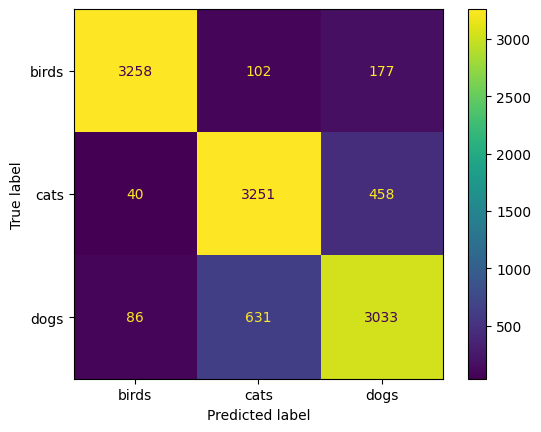

In [48]:
balanced_cm = confusion_matrix(y_true, y_pred_balanced)
ConfusionMatrixDisplay(balanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

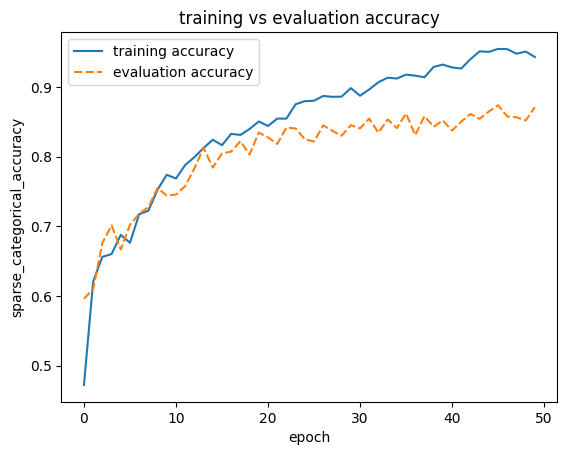

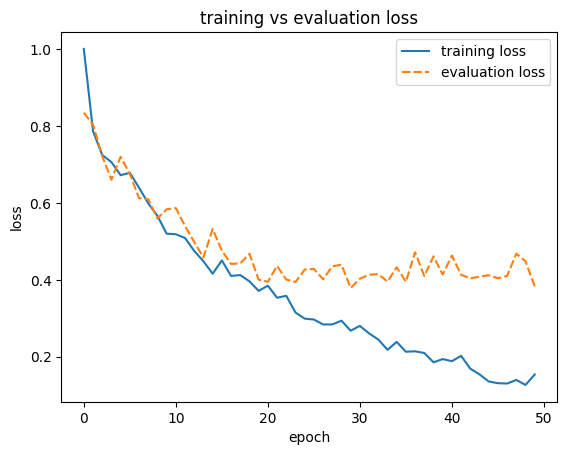

In [49]:
plot_train_eval(balanced_history)

# Training with Data Augmentation

is a technique in which you create new versions of the image, by applying geometric transformations. This helps in further exploring the feature space and hence reducing the chances of overfitting.


In [50]:
# Create a model to use with the balanced and augmented dataset
augmented_model = create_model()

In [51]:
# Now applying image augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Still pointing to directory with full dataset
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/tmp/data/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 25750 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.


 **this was only done to the training generator since this technique should only be applied to the training images.**

 Let's see these transformations in action.


Transformation number: 0



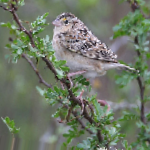


Transformation number: 1



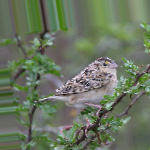


Transformation number: 2



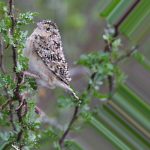


Transformation number: 3



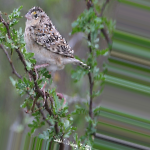

In [52]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img


# Displays transformations on random images of birds in the training partition
def display_transformations(gen):
  train_birds_dir = "/tmp/data/train/birds"
  random_index = random.randint(0, len(os.listdir(train_birds_dir)))
  sample_image = load_img(f"{os.path.join(train_birds_dir, os.listdir(train_birds_dir)[random_index])}", target_size=(150, 150))
  sample_array = img_to_array(sample_image)
  sample_array = sample_array[None, :]


  for iteration, array in zip(range(4), gen.flow(sample_array, batch_size=1)):
    array = np.squeeze(array)
    img = array_to_img(array)
    print(f"\nTransformation number: {iteration}\n")
    display(img)


# An example of an ImageDataGenerator
sample_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.2,
        zoom_range=0.25,
        horizontal_flip=True)

display_transformations(sample_gen)

In [53]:
# Load pretrained model and history

augmented_history = pd.read_csv('history-augmented/history-augmented.csv')
augmented_model = tf.keras.models.load_model('model-augmented')

In [54]:
# Run only if you want to train the model yourself (this takes around 20 mins with GPU enabled)

# augmented_history = augmented_model.fit(
#     train_generator,
#     steps_per_epoch=100,
#     epochs=80,
#     validation_data=validation_generator,
#     validation_steps=80)

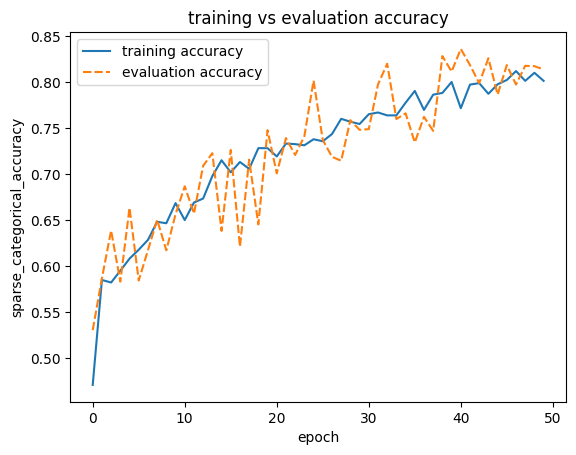

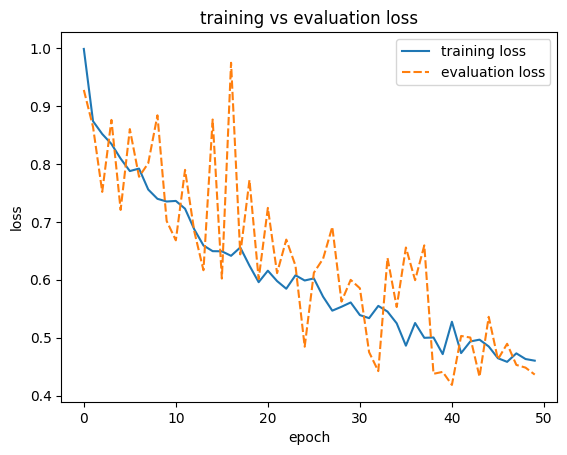

In [55]:
plot_train_eval(augmented_history)

In [60]:
augmented_model.save('model_CNN')

Now, the evaluation accuracy follows more closely the training one

In [59]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [66]:
!cp -r model_CNN '/content/drive/My Drive/'

